In [1]:
import subprocess

In [2]:
from IPython.display import Image, display

In [3]:
from ase.build import bulk

In [4]:
from ovito.io import export_file

In [5]:
from ovito.io.ase import ase_to_ovito

In [6]:
from ovito.pipeline import Pipeline, StaticSource

# ASE

In [7]:
cu_atoms = bulk('Cu', 'fcc', a=3.6)

In [8]:
atoms = cu_atoms.repeat([4,4,4])

# Ovito

In [9]:
pipeline = Pipeline(source = StaticSource(data = ase_to_ovito(atoms)))

In [10]:
export_file(pipeline, "ovito.pov",  "povray")

In [11]:
def shinify(
    input_filename, output_filename, specular=0.8,
    reflection=0.8, diffuse=0.8, light_intensity=1,
    light_location=(None, None, None)
):

    """
    Adds finish properties to .pov output files generated from Ovito.
    
    args:
        input_filename (str): existing .pov file created by Ovito
        output_filename (str): desired filename for "shiny" .pov file
        specular, reflection, diffuse: finish parameters from POV-Ray, applied to spheres (atoms) and cylinders (bonds)
            see https://www.povray.org/documentation/view/3.6.1/79/ for more details/options.
        light_intensity (float): multiplier for light intensity
        light_location (tuple): x, y, and z coordinates of light fixture in the scene. You might have to use trial
            and error to find the best location if Ovito's default isn't what you want.
    """

    lines = open(input_filename).readlines()
    with open(output_filename, "w") as f:
        i = 0
        light_fixed = False
        while i < len(lines):
            line = lines[i]

            # Add your own lighting
            # you can also mess with the light color and its intensity
            if line.split()[0] == "light_source" and light_location[0] is not None:
                f.write(
                    "light_source {\n"
                    + f"  <{light_location[0]}, {light_location[1]}, {light_location[2]}>\n"
                    + "  color <{light_intensity}, {light_intensity}, {light_intensity}>\n"
                    + "}\n"
                )
                i += 6
                
            # Add shiny finish to spherical atoms
            if line[0:14] == "#macro SPRTCLE":
                f.write(
                    "#macro SPRTCLE(pos, particleRadius, particleColor, spc, ref, dif) // Macro for spherical particles\n"
                    + "sphere { pos, particleRadius\n"
                    + "         texture { pigment { color particleColor } finish { specular spc reflection ref diffuse dif } }\n"
                    + "}\n#end\n"
                )
                i += 4
            elif line.split("(")[0] == "SPRTCLE":
                f.write(line.replace(")", f", {specular}, {reflection}, {diffuse})"))
            
            # Add shiny finish to cylindrical bonds
            elif line[0:10] == "#macro CYL":
                f.write(
                    "#macro CYL(base, dir, cylRadius, cylColor, spc, ref, dif) // Macro for cylinders\n"
                    + "cylinder { base, base + dir, cylRadius\n"
                    + "         texture { pigment { color cylColor } finish { specular spc reflection ref diffuse dif } }\n"
                    + "}\n#end\n"
                )
                i += 4
            elif line.split("(")[0] == "CYL":
                f.write(line.replace(")", f", {specular}, {reflection}, {diffuse})"))
            else:
                f.write(line)
            i += 1



In [12]:
shinify("ovito.pov", "ovito_shiny.pov")

In [13]:
subprocess.check_output(["povray", "+H800", "+W800", "+Iovito_shiny.pov", "+Oovito.png", "+UA"])

b''

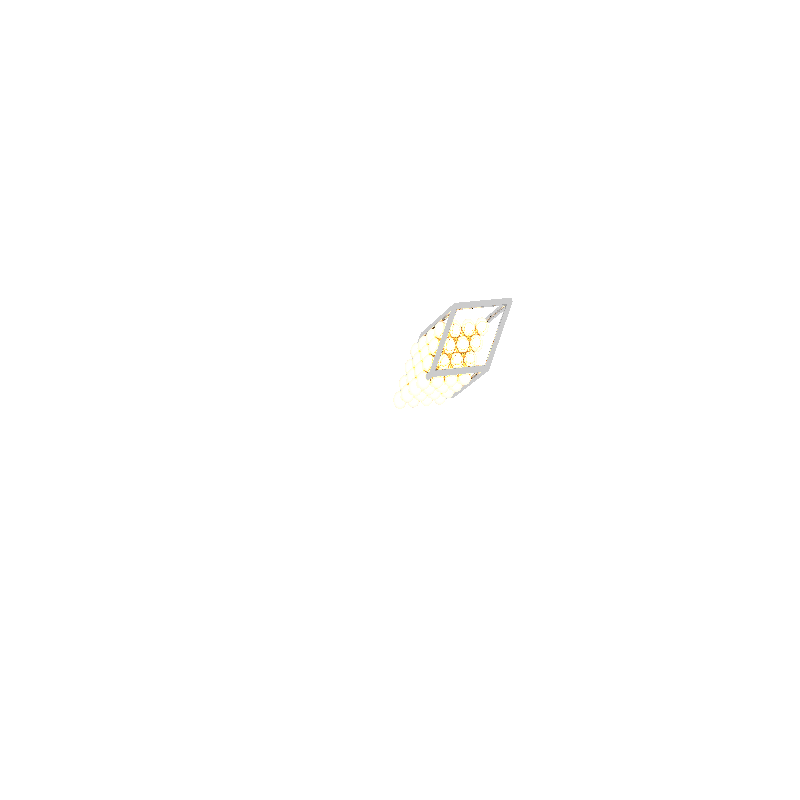

In [14]:
display(Image("ovito.png"))